Here are the relevant columns you need to know

Col 2 T90

Col 3 error in T90

Col 4 fluence in 20-50 keV (F1)

Col  5 error in fluence in 20- 50 keV  (eF1)

Col 6  fluence in 50- 100 keV (F2)

Col 7  error in  fluence in 50- 100 keV (eF2)

For T90 use Col 2

So hardness ratio for BATSE will be F2/F1 or Col 6/Col 4

and ln(hardness) would  ln (col6/col4)

For our analysis since we only need the error in ln(hardness) we can do error propagation to calculate this

error in ln(hardness) = Error [ ln(f2) -ln(F1)]
                                 = sqrt [ (eF2/F2)^2 + (eF1/F1)^2]



In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
#from astroML.plotting.tools import draw_ellipse
import itertools
from scipy import linalg
import matplotlib as mpl
from matplotlib.colors import LogNorm
from sklearn import mixture
from xdgmm import XDGMM
# from astroML.density_estimation import XDGMM

In [2]:
arr = np.genfromtxt("batse_final_catalog.txt", dtype=float,delimiter = " ")
print(arr[0,:])

COLUMN_T90_ERROR = 2
COLUMN_T90 = 1
COLUMN_FLUENCE_50_100 = 5
COLUMN_FLUENCE_25_50 = 3
COLUMN_FLUENCE_50_100_ERROR = 6
COLUMN_FLUENCE_25_50_ERROR = 4

[1.0500e+02 5.1840e+00 1.8100e-01 8.6850e-07 1.0887e-08 1.3209e-06
 1.4368e-08 2.0468e-06 1.7931e-07 1.0321e-06 1.7931e-07 1.2761e+01
 5.4400e-01 3.8400e+00 1.1857e+01 2.6500e-01 3.8400e+00 9.9370e+00
 1.2300e-01 4.1600e+00]


In [3]:
t90=[]
hr=[]
dt90=[]
dhr=[]

for i in range(len(arr)):
    hr_ratio = 0
    if arr[i][COLUMN_FLUENCE_25_50] > 0:
        hr_ratio = arr[i][COLUMN_FLUENCE_50_100] / arr[i][COLUMN_FLUENCE_25_50]
    
    if arr[i][COLUMN_T90] > 0 and hr_ratio > 0 and arr[i][COLUMN_FLUENCE_50_100] > 0 and arr[i][COLUMN_FLUENCE_25_50] > 0:
        t90.append(math.log(arr[i][COLUMN_T90]))
        hr.append(math.log(hr_ratio))
        err_hr_50_100 = (arr[i][COLUMN_FLUENCE_50_100_ERROR]/arr[i][COLUMN_FLUENCE_50_100])
        err_hr_25_50 = (arr[i][COLUMN_FLUENCE_25_50_ERROR]/arr[i][COLUMN_FLUENCE_25_50])
        error_hr = math.sqrt(err_hr_50_100 ** 2 +  err_hr_25_50** 2)
        dhr.append(error_hr)
        dt90.append((arr[i][COLUMN_T90_ERROR]))
print(len(dt90))

1934


In [5]:
# stack the data 
X = np.vstack([t90, hr]).T
X = X[~np.isnan(X).any(axis=1)]
X = X[np.isfinite(X).any(axis=1)]

#change list to matrix
mat_dt90 = np.zeros(len(dt90))
mat_dhr = np.zeros(len(dhr))
for i in range(len(dhr)):
    mat_dt90[i] = dt90[i]
    mat_dhr[i] = dhr[i]

# stack data error
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([mat_dt90**2, mat_dhr**2]).T

In [6]:
# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.arange(1,6)
xdgmm = XDGMM()


In [7]:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X, Xerr, param_range)
aic, optimal_aic_n_comp, lowest_aic = xdgmm.aic_test(X, Xerr, param_range)

N = 1 , BIC = 11681.694253751182
N = 2 , BIC = 11542.530399212024
N = 3 , BIC = 11536.868184273302
N = 4 , BIC = 11575.227060381769


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


N = 5 , BIC = 11616.852401669934
N = 1 , BIC = 11681.694253751182
N = 2 , BIC = 11542.530399212024
N = 3 , BIC = 11537.026198474061
N = 4 , BIC = 11575.41452608835


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


N = 5 , BIC = 11611.208766119333


N = 1 , AIC = 16456.27343476342
N = 2 , AIC = 16468.27343476342
N = 3 , AIC = 16480.27343476342
N = 4 , AIC = 16492.27343476342
N = 5 , AIC = 16504.27343476342


https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html

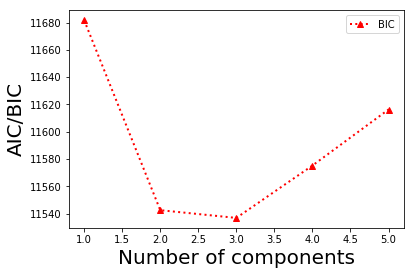

In [31]:
plt.plot(param_range, aics, '-k', label='AIC',color ='blue', marker='o',lw=2)
plt.plot(param_range, bic, ':k', label='BIC', color = 'red', marker='^',lw=2)
plt.legend(loc=1)
plt.xlabel('Number of components',size=20 )
plt.ylabel('AIC/BIC', size=20)
plt.show()